# Retinal CNV Segmentasyonu Projesi

## Problem Tanımı
Retinal Choroidal Neovascularization (CNV), retina üzerinde anormal damar büyümeleriyle karakterize edilen bir hastalıktır. CNV, görme kaybına yol açabilen bir durumdur ve erken teşhisi önemlidir. Bu projede, retinal görüntüler üzerinde CNV segmentasyonu yapmak hedeflenmektedir. CNV segmentasyonu, retina hastalıklarının daha doğru ve hızlı teşhis edilmesine yardımcı olacaktır.

## Amaç
Bu projenin amacı, retinal görüntülerdeki CNV bölgelerinin doğru bir şekilde segmentasyonunu yaparak, otomatik tıbbi teşhis sistemlerine katkıda bulunmaktır. Bu, sağlık profesyonellerine daha verimli bir şekilde teşhis koyma imkanı sunacaktır.

## Personele Katkısı
Bu proje, sağlık profesyonellerinin CNV'yi daha hızlı bir şekilde teşhis etmelerine yardımcı olacak bir araç geliştirmeyi amaçlamaktadır. Ayrıca, tıbbi görüntü analizi alanında yeni algoritmaların geliştirilmesine katkı sağlayacaktır.

## Veri Seti Tanımı
Veri seti, retinal görüntülerden oluşan bir koleksiyondan alınmıştır. Bu görüntüler, CNV segmentasyonu yapmak için etiketlenmiştir ve üç ana bölüme ayrılmaktadır:
- **Test Görüntüleri**: `/Users/koray/Desktop/24/test/` 
- **Train Görüntüleri**: `/Users/koray/Desktop/24/train/` 
- **Validation Görüntüleri**: `/Users/koray/Desktop/24/val/`
- Bütün görüntülerin boyutları 512x512'dir.

![Label İlk Görüntü](../Desktop/24/label/label1.png)
![Train İlk Görüntü](../Desktop/24/train/cnvt1.jpeg)



### Kütüphanelerin İmport Edilmesi

In [3]:
import logging
import os
import sys
import tempfile
from glob import glob
import numpy as np

import torch
from PIL import Image
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import ArrayDataset, create_test_image_2d, decollate_batch, DataLoader
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity)
from monai.visualize import plot_2d_or_3d_image
import matplotlib.pyplot as plt

### Klasördeki Görüntü ve Maskelerin Değişkene Atanması

In [5]:
from glob import glob
import os
import re

def natural_sort_key(text):
    """Doğal sıralama için anahtar fonksiyonu."""
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', text)]

image_path = "/Users/koray/Desktop/24/train"
label_path = "/Users/koray/Desktop/24/label"
#test_image_path = "/Users/koray/Desktop/24/test"
#test_label_path = "/Users/koray/Desktop/24/test-label"

# Dosya yollarını al ve doğal sırayla sırala
images = sorted(glob(os.path.join(image_path, "cnvt*.jpeg")), key=natural_sort_key)
labels = sorted(glob(os.path.join(label_path, "label*.png")), key=natural_sort_key)
#images1 = sorted(glob(os.path.join(test_image_path, "cnvt*.jpeg")), key=natural_sort_key)
#labels1 = sorted(glob(os.path.join(test_label_path, "label*.png")), key=natural_sort_key)

print(f"Images: {len(images)} adet dosya bulundu.")
print(f"Labels: {len(labels)} adet dosya bulundu.")

# İlk 3 görüntü ve etiket yollarını sırayla yazdır
for i in range(min(3, len(images), len(labels))):  # Sadece hem görüntü hem etiket olduğu sürece döngü yapar
    print(f"Görüntü {i+1}: {images[i]}")
    print(f"Etiket {i+1}: {labels[i]}")

Images: 40 adet dosya bulundu.
Labels: 40 adet dosya bulundu.
Görüntü 1: /Users/koray/Desktop/24/train/cnvt1.jpeg
Etiket 1: /Users/koray/Desktop/24/label/label1.png
Görüntü 2: /Users/koray/Desktop/24/train/cnvt2.jpeg
Etiket 2: /Users/koray/Desktop/24/label/label2.png
Görüntü 3: /Users/koray/Desktop/24/train/cnvt3.jpeg
Etiket 3: /Users/koray/Desktop/24/label/label3.png


### İlk 3 görüntünün ekranda gösterilmesi

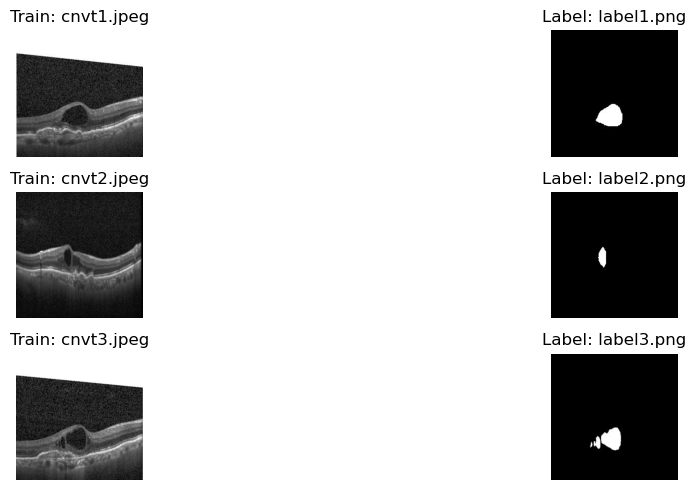

In [7]:
import matplotlib.pyplot as plt
from PIL import Image

num_samples = 3  
train_images = [Image.open(images[i]) for i in range(num_samples)]  
train_labels = [Image.open(labels[i]) for i in range(num_samples)]  

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    
    plt.subplot(num_samples, 2, 2 * i + 1)
    plt.imshow(train_images[i], cmap="gray")  
    plt.title(f"Train: {os.path.basename(images[i])}")
    plt.axis("off")
    
    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.imshow(train_labels[i], cmap="gray")  
    plt.title(f"Label: {os.path.basename(labels[i])}")
    plt.axis("off")

plt.tight_layout()
plt.show()

###  [Compose](https://docs.monai.io/en/stable/transforms.html): Görüntü üzerinde yapılacak dönüşümleri birleştir

In [12]:
from monai.transforms import RandSpatialCropSamples, RandRotate90
## İlk gelen görüntüyü ekrana bas
# Görüntüler için dönüşüm (augmentation işlemleri ve 96x96 parçalara ayırma)
## label üzerinde merkez göze alınarak 
train_imtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        ScaleIntensity(),
        ## medyan filtre komutu koy
        RandSpatialCropSamples(roi_size=(96, 96), num_samples=100, random_center=True, random_size=False),  # 96x96 parçalar, 3 farklı örnek
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),  # Augmentasyon: %50 olasılıkla 90 derece döndür
    ]
)

# Etiketler için dönüşüm (görsellerle aynı işlemler)
train_labeltrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        ScaleIntensity(),
        RandSpatialCropSamples(roi_size=(96, 96), num_samples=100, random_center=True, random_size=False),  # 96x96 parçalar, 3 farklı örnek
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),  # Augmentasyon: %50 olasılıkla 90 derece döndür
    ]
)

# Test için dönüşümler
test_imtrans = Compose([LoadImage(image_only=True, ensure_channel_first=True), ScaleIntensity()])
test_labeltrans = Compose([LoadImage(image_only=True, ensure_channel_first=True), ScaleIntensity()])

# Çıktı için dönüşüm
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

###  [Arraydataset](https://docs.monai.io/en/stable/data.html#arraydataset): Klasördeki görüntülerin okunması ve dönüştürülmesi nesnesi:

In [15]:
ds = ArrayDataset(images, train_imtrans, labels, train_labeltrans)
## ekranda 

### [DataLoader](https://https://docs.monai.io/en/stable/modules.html#datasets-and-data-loading): Yüklenen veri nesnesi


In [18]:
loader = DataLoader(ds, batch_size=10, num_workers=2, pin_memory=torch.cuda.is_available())


### İlk görseller

In [21]:
def goster(goruntuler):
    n = len(goruntuler)  # Görüntü sayısını belirle
    fig, axs = plt.subplots(1, n, figsize=(5*n, 5))

    for i, goruntu in enumerate(goruntuler):
        axs[i].imshow(goruntu, cmap='gray')  # Görüntüyü çiz
        axs[i].axis('off')  # Eksenleri gizle

    plt.tight_layout()
    plt.show()

torch.Size([10, 1, 96, 96]) torch.Size([10, 1, 96, 96])


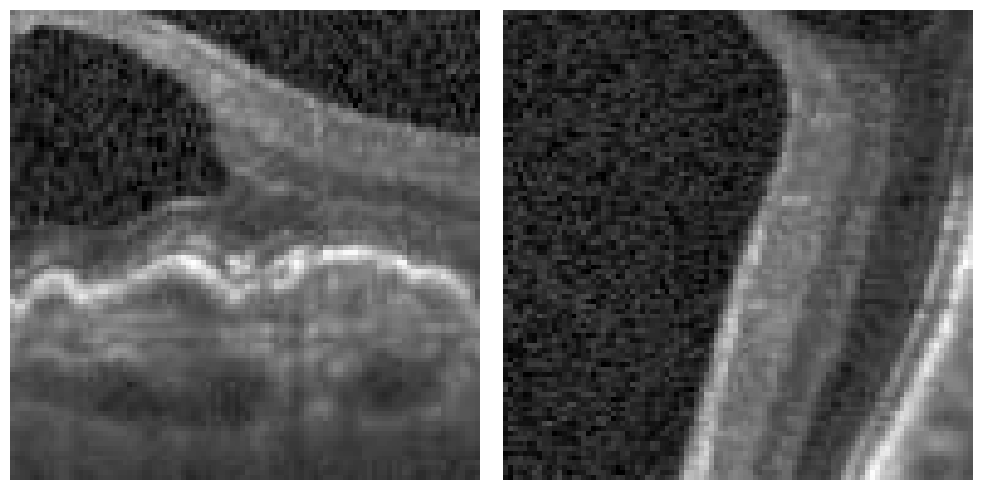

In [23]:
# Veri kümesinden ilk batch'i al
batch = monai.utils.misc.first(loader)


# Eğer batch'in ilk öğesi görüntü ve etiket içeriyorsa
# Batch'in birden fazla öğe içerip içermediğini kontrol edelim
im = batch[0]  # Görüntü
label = batch[1]  # Etiket

print(im.shape, label.shape)

# Görüntü ve etiketleri göster
goster([im[0, 0].cpu().numpy(), label[0, 0].cpu().numpy()])

### Eğitim için ilk 40, test için son 40

In [25]:
train_ds = ArrayDataset(images[:40], train_imtrans, labels[:40], train_labeltrans)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, pin_memory=torch.cuda.is_available())

test_ds = ArrayDataset(images[-40:], test_imtrans, labels[-40:], test_labeltrans)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4, pin_memory=torch.cuda.is_available())

### Benzerlik ölçümü için metrik tanımı

In [29]:
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

### Modeli oluştur: UNet, DiceLoss and Adam optimizer

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,  
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

### Eğitime başla

In [35]:
epoch_loss_values = list()
writer = SummaryWriter()
for epoch in range(5): # bütün veriyi 5 defa gör
    print("-" * 20)
    print(f"epoch {epoch + 1}/{5}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader: # batch=4 oldugu icin, iterasyon
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device) # GPU ya taşı
        optimizer.zero_grad()
        outputs = model(inputs)  # YZ modeline ver
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

--------------------
epoch 1/5
1/10, train_loss: 0.6817
2/10, train_loss: 0.6663
3/10, train_loss: 0.6175
4/10, train_loss: 0.6922
5/10, train_loss: 0.6886
6/10, train_loss: 0.6886
7/10, train_loss: 0.6803
8/10, train_loss: 0.6848
9/10, train_loss: 0.6995
10/10, train_loss: 0.7157
epoch 1 average loss: 0.6815
--------------------
epoch 2/5
1/10, train_loss: 0.7692
2/10, train_loss: 0.6783
3/10, train_loss: 0.6990
4/10, train_loss: 0.7679
5/10, train_loss: 0.6754
6/10, train_loss: 0.6625
7/10, train_loss: 0.6241
8/10, train_loss: 0.6891
9/10, train_loss: 0.6722
10/10, train_loss: 0.6455
epoch 2 average loss: 0.6883
--------------------
epoch 3/5
1/10, train_loss: 0.6678
2/10, train_loss: 0.7063
3/10, train_loss: 0.7346
4/10, train_loss: 0.6908
5/10, train_loss: 0.7058
6/10, train_loss: 0.8190
7/10, train_loss: 0.7235
8/10, train_loss: 0.7695
9/10, train_loss: 0.6553
10/10, train_loss: 0.6924
epoch 3 average loss: 0.7165
--------------------
epoch 4/5
1/10, train_loss: 0.6171
2/10, train

### Modeli Kaydet

In [37]:
torch.save(model.state_dict(), "tmp\model.pth")

### Test Çıktısını Al

In [39]:
img = 0
roi_size = (256, 256)
sw_batch_size = 4
c = 1
Num = 50
for test_data in test_loader:
    if c < Num:
        continue
    test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
    test_outputs = sliding_window_inference(test_images, roi_size, sw_batch_size, model)
    test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]
    goster([test_images[0][0].cpu().detach().numpy(), test_labels[0][0].cpu().detach().numpy(),test_outputs[0][0].cpu().detach().numpy()])
